# Mô hình Hidden Markov Gaussian


### BS. Lê Ngọc Khả Nhi


# Nhập đề

Trong thời gian nằm viện, một vài thông số sinh lý của bệnh nhân thường được khảo sát lặp lại nhiều lần để theo dõi diễn tiến của bệnh lý, và cập nhật thông tin cho phép bác sĩ thay đổi chế độ điều trị phù hợp, kịp thời. Quy trình theo dõi này sinh ra dữ liệu dạng chuỗi (sequential data) chứa nhiều thông tin thú vị; tuy nhiên dạng dữ liệu chuỗi hiếm khi được khai thác trong nghiên cứu khoa học; hoặc nếu có thì mỗi thời điểm thường được khảo sát như những quan sát độc lập bằng repeated ANOVA, Mixed model, paired-samples t-test, những cách làm này đã bỏ qua yếu tố "thời gian", "chuyển tiếp" của dữ liệu chuỗi.

Một trong những phương pháp thống kê thích hợp cho dữ liệu chuỗi đó là mô hình Markov ẩn (Hidden Markov model, viết tắt: HMM). Mô hình HMM giả định rằng giá trị quan sát là kết quả của một tiến trình Markov mang tính ngẫu nhiên (stochastic process) gồm các tham số trạng thái chưa xác định (trạng thái ẩn, hidden state X) với xác suất ban đầu (initial probability). Sự chuyển tiếp giữa các tham số trạng thái ẩn được xác định bằng xác suất chuyển tiếp (transition probability). Xác suất đầu ra (emission probability) cho phép liên kết mỗi trạng thái ẩn với kết quả quan sát được.

Trong thí nghiệm hôm nay, Nhi sẽ áp dụng mô hình HMM Gaussian emission (HMMGE) với đầu ra là biến định lượng, giả định theo phân bố Gaussian) để khảo sát một bộ dữ liệu theo dõi độ bão hòa Oxy máu (SpO2) trong thời gian nằm viện của 35 bệnh nhân nhiễm COVID-19. Có thể xem đây là 1 bài toán Unsupervised learning.

Chúng ta bắt đầu thí nghiệm nhé ?

In [1]:
# Công cụ
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import tensorflow_probability as tfp

# Đồ họa
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

# network
import networkx as nx
from graphviz import Source

# HMMG
from hmmlearn.hmm import GaussianHMM

# Chuẩn bị dữ liệu

Trước hết, Nhi tải dữ liệu gốc:

In [2]:
path = 'covidspo2.csv'
df = pd.read_csv(path, sep =';')

df

,Patient,Time,Oxygen,Flow,SpO2
0,CC220447,09/04/2020 08:00,Non,0.0,93
1,CC220447,09/04/2020 05:00,Non,0.0,95
2,CC220447,08/04/2020 22:00,Non,0.0,97
3,CC220447,08/04/2020 08:00,Non,0.0,94
4,CC220447,08/04/2020 05:00,Non,0.0,95
...,...,...,...,...,...
1204,RR000,27/03/2020 22:00,Oui,2.0,97
1205,RR000,27/03/2020 20:00,Oui,2.0,97
1206,RR000,27/03/2020 16:00,Oui,3.0,97
1207,RR000,27/03/2020 12:00,Oui,2.0,98


Quan sát cho thấy dữ liệu có dạng bảng dọc (Long table format), trong đó mỗi bệnh nhân được mã hóa bằng 1 chuỗi string (cột Patient), và liên kết với 3 chuỗi: Oxygen = biến định tính, Có thở oxy hay không, Flow = Lưu lượng oxy cung cấp; và SpO2. Nhi cũng nhận ra là trình tự của chuỗi bị đảo ngược (từ ngày cuối ngược dần về ngày đầu nhập viện) - xem cột Time.

Để đơn giản, ta chỉ quan tâm đến 1 chuỗi là SpO2; đơn vị quan sát của mô hình HMM là chuỗi nên Nhi cần tạo ra 1 database dạng dictionary, trong đó keys = tên mỗi bệnh nhân là duy nhất, tương ứng với value = 1 array ghi giá trị SpO2 theo trình tự thời gian xuôi (nhập viện-xuát viện). 

In [3]:
def create_seq_db(path = 'covidspo2.csv', target = 'SpO2'):
    df = pd.read_csv(path, sep =';')
    df['Time'] = pd.to_datetime(df['Time'])

    patients = np.unique(df['Patient'])
    seq_db = dict.fromkeys(patients)
    
    for p in patients:
        seq_db[p] = np.array(df[df['Patient'] == p][target].iloc[::-1])
        
    return seq_db

Áp dụng hàm create_seq_db, Nhi có database cần thiết:

In [4]:
seq_db = create_seq_db('covidspo2.csv')

seq_db

{'BT000000': array([96, 98, 97, 98, 98, 98, 97, 96, 98, 97, 96, 95, 98, 94],
       dtype=int64),
 'CBCor': array([96, 92, 89, 85, 95, 88, 93, 94, 94, 94, 88, 87, 92, 84, 94, 91, 87,
        64, 67], dtype=int64),
 'CC220447': array([91, 89, 73, 94, 93, 95, 94, 97, 95, 93], dtype=int64),
 'DBV000000': array([97, 94, 94, 94, 94, 96, 94, 94, 95, 97, 97, 96, 94, 96, 95, 96],
       dtype=int64),
 'DE230768': array([94, 94, 96, 94, 95, 96, 93, 94, 95, 95, 94, 94, 90, 94, 95, 97, 97,
        98, 99, 97, 99, 99, 97, 98, 97, 99, 98, 98, 99], dtype=int64),
 'DJ000000': array([97, 93, 94, 95, 98, 97, 99, 99, 92, 94, 92, 95, 96, 96, 93, 94, 94,
        91, 97, 97, 90, 93, 91, 99, 97, 96, 90, 91, 95, 85, 88, 91, 90, 80,
        90, 83, 70, 83, 90, 82, 90, 77, 73, 74, 96, 74, 73, 69],
       dtype=int64),
 'FC000000': array([96, 97, 97, 94, 97, 95, 97, 96, 97, 99, 96, 96, 97, 96, 97, 98, 95,
        96], dtype=int64),
 'FJ000000': array([95, 93, 94, 94, 95, 97, 93, 97, 97, 98, 97, 95, 97, 98, 96, 

Danh sách bệnh nhân và độ dài chuỗi SpO2 của họ:

In [5]:
lengths = [len(seq_db[p]) for p in seq_db.keys()]

pd.DataFrame({'Patient':list(seq_db.keys()), 'Len': lengths})

,Patient,Len
0,BT000000,14
1,CBCor,19
2,CC220447,10
3,DBV000000,16
4,DE230768,29
5,DJ000000,48
6,FC000000,18
7,FJ000000,22
8,FJQ160143,55
9,FN230635,80


Ta quan sát một vài chuỗi SpO2 của các bệnh nhân chọn ngẫu nhiên:

In [10]:
def plot_seq(patient = 'GMA000', color = 'red'):
    spo2 = seq_db[patient]
    matplotlib.rcParams.update({'font.size': 15})
    plt.figure(figsize=(24,5))
    
    plt.title(f'SpO2 sequence of patient {patient}')
    plt.fill_between(np.arange(spo2.shape[0]),
                     np.repeat(np.min(spo2)-2, spo2.shape[0]),
                     spo2,
                     color = color,
                     step="pre", 
                     alpha=0.3)
    plt.xlabel('Time points')
    plt.ylabel('SpO2')

    plt.plot(np.arange(spo2.shape[0]),
             spo2,
             color = color,
             drawstyle="steps", 
             alpha = 0.4)

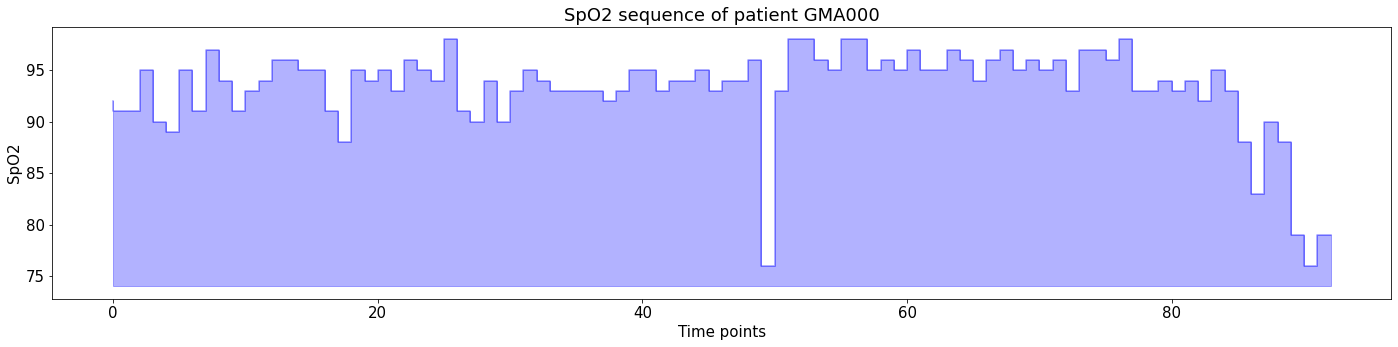

In [12]:
plot_seq('GMA000', 'blue')

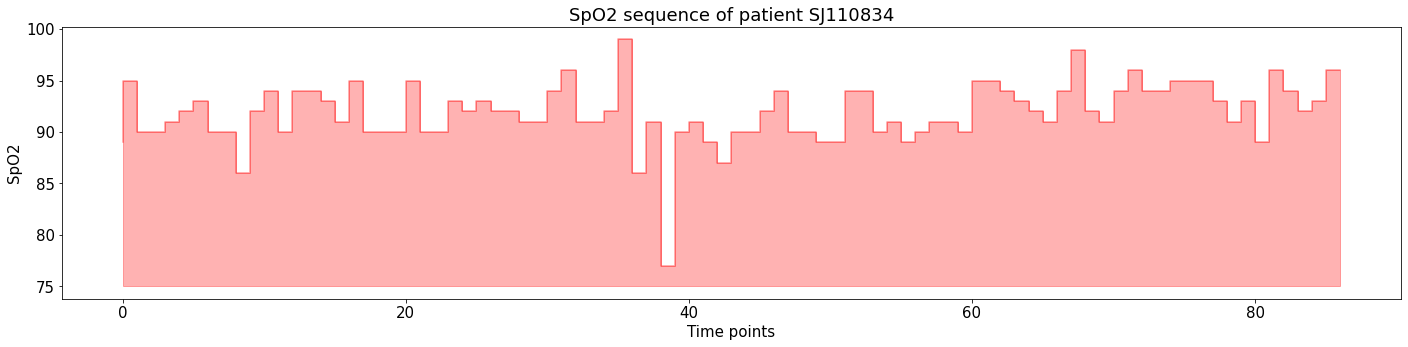

In [13]:
plot_seq('SJ110834', 'red')

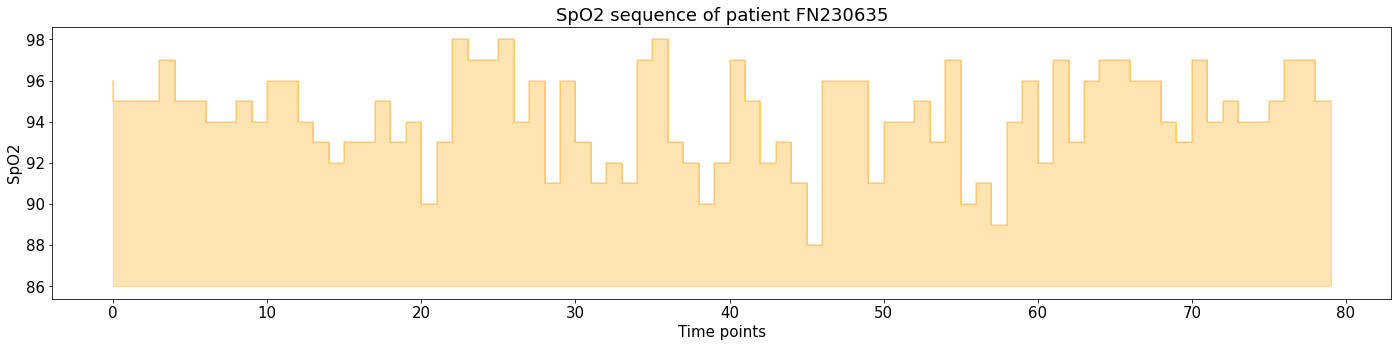

In [14]:
plot_seq('FN230635', 'orange')

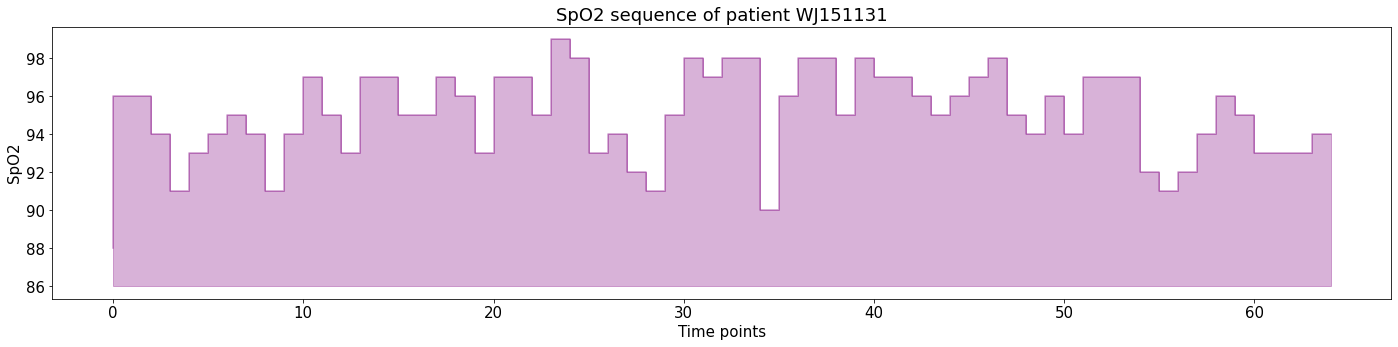

In [15]:
plot_seq('WJ151131', 'purple')

# Dựng mô hình 

Nhi dùng method GaussianHMM của thư viện hmmlearn, với algorithm là Viterbi để luyện một mô hình HMM với đầu ra phân phối Gaussian; đặc biệt việc huấn luyện thực hiện trên nhiều đơn vị quan sát (chuỗi) với độ dài khác nhau.

Để thực hiện điều này, đầu vào cần có X là 1 array 2 chiều, và cần 1 array lengths chứa độ dài của từng chuỗi (ta đã có ở trên).

In [19]:
# Dữ liệu đầu vào có dạng thế này:

X = np.concatenate([seq_db[p] for p in seq_db.keys()])

np.atleast_2d(X).T

array([[96],
       [98],
       [97],
       ...,
       [93],
       [93],
       [94]], dtype=int64)

In [21]:
print(lengths)

[14, 19, 10, 16, 29, 48, 18, 22, 55, 80, 40, 30, 93, 23, 43, 19, 19, 42, 77, 51, 18, 32, 19, 18, 14, 13, 15, 8, 59, 54, 26, 17, 87, 16, 65]


Một tham số quan trọng mang tính chủ quan trong mô hình HMM, đó là số hidden states (n components) mà ta muốn giả định; Nhi sẽ khảo sát score của mô hình với giá trị n từ 2 đến 12:

Một tham số khác, đó là cách tính covariance, có 2 phương pháp là Diag và full (giống như trong algorithm Gaussian Mixture clustering), tuy nhiên sẽ không có khác biệt nếu dữ liệu chỉ gồm 1 chuỗi duy nhất (SpO2), trong trường hợp có nhiều chuỗi song song, phương pháp 'Full' có thể cho ra kết quả khác với 'Diag'

Text(0.5, 0, 'n_components')

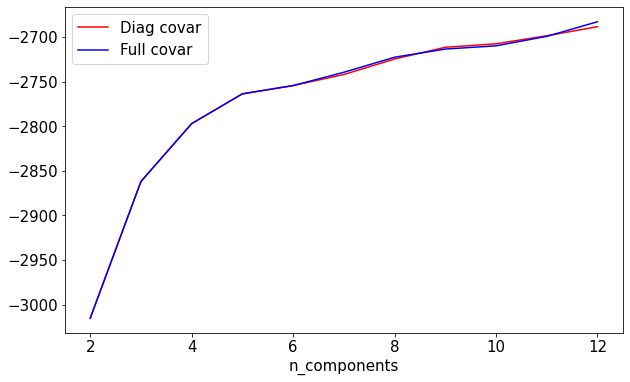

In [25]:
n_components = np.arange(2, 13)

models1 = [GaussianHMM(n_components=n, 
                    covariance_type="diag",
                    n_iter=2000).fit(np.atleast_2d(X).T, lengths)
           for n in n_components]
          
models2 = [GaussianHMM(n_components=n, 
                    covariance_type="full",
                    n_iter=2000).fit(np.atleast_2d(X).T, lengths)
           for n in n_components]
         
plt.figure(figsize=(10,6))

plt.plot(n_components, 
         [m.score_samples(np.atleast_2d(X).T, lengths)[0] for m in models1], label='Diag covar',
         c = 'red'
        )
          
plt.plot(n_components, 
         [m.score_samples(np.atleast_2d(X).T, lengths)[0] for m in models2], label='Full covar',
         c = 'blue'
        )

plt.legend(loc='best')
plt.xlabel('n_components')

Có vẻ như một mô hình với 5 hidden states là phù hợp; ta sẽ dựng mô hình này

In [26]:
model = GaussianHMM(n_components=5, 
               covariance_type="diag",
               n_iter=5000)

model.fit(np.atleast_2d(X).T, lengths)

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=5, n_iter=5000, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

# Diễn giải mô hình

Đầu tiên, Nhi sẽ khảo sát đặc tính phân bố của 5 trạng thái ẩn mà mô hình học được từ dữ liệu:

In [28]:
print("Trung bình ± SD tương ứng 5 hidden states")

for i in range(model.n_components):
    print(f'{i}th hidden state')
    print(f'{float(model.means_[i])} ± {float(np.diag(model.covars_[i])**0.5)}')
    print('-'*40)

Trung bình ± SD tương ứng 5 hidden states
0th hidden state
97.87891639420545 ± 0.8128419110991656
----------------------------------------
1th hidden state
90.80917007433679 ± 2.511330051159424
----------------------------------------
2th hidden state
93.93331886555568 ± 1.9248274230272753
----------------------------------------
3th hidden state
82.41847411162121 ± 8.91257013052585
----------------------------------------
4th hidden state
96.1279816142075 ± 1.2372715933339342
----------------------------------------


Hình ảnh của 5 phân bố Gaussian tương ứng  hidden states của mô hình HMMG:

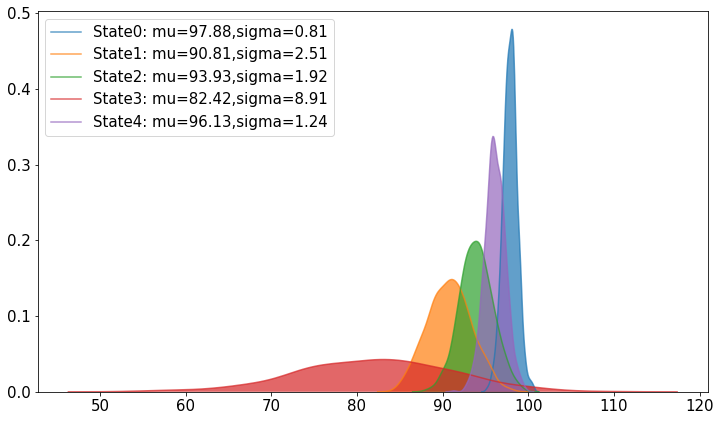

In [31]:
tfd = tfp.distributions

mu = model.means_.flatten()
sd = model.covars_.flatten()**0.5

plt.figure(figsize=(12,7))

for i in [0,1,2,3,4]:
    loc = tf.constant(mu[i])
    scale =  tf.constant(sd[i])
    dist = tfd.Normal(loc = loc, scale = scale)
    samples = dist.sample(1000).numpy()
    
    sns.kdeplot(pd.Series(samples, name = str(f'State{i}: mu={np.round(loc,2)},sigma={np.round(scale,2)}')),shade = True, alpha = 0.7)

Ma trận chuyển tiếp giữa 5 trạng thái ẩn được xuất ra từ mô hình như sau:

In [32]:
tm_df = pd.DataFrame(model.transmat_, 
                     columns=np.round(model.means_.flatten(),2),
                     index=np.round(model.means_.flatten(),2))

tm_df

,97.88,90.81,93.93,82.42,96.13
97.88,8.267844e-01,3.330622e-30,0.124441,1.402555e-52,4.877486e-02
90.81,3.813857e-06,8.918647e-01,0.050722,4.964190e-02,7.767641e-03
93.93,2.124992e-02,1.828578e-02,0.908204,8.361198e-03,4.389947e-02
82.42,1.307522e-30,3.821833e-02,0.118668,8.431137e-01,1.831411e-08
96.13,7.587430e-04,3.966586e-08,0.084482,1.934286e-06,9.147577e-01


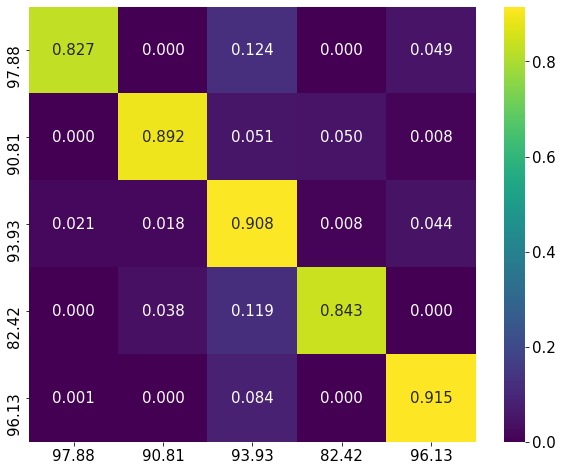

In [35]:
plt.rcParams['figure.figsize'] = (10,8)

sns.heatmap(tm_df, cmap = 'viridis', annot=True, fmt=".3f")

Từ ma trận chuyển tiếp, ta có thể vẽ thành mô hình mạng (network) như sau:

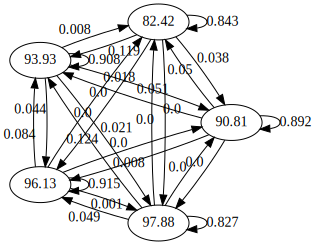

In [36]:
states = [str(i) for i in tm_df.index]

def get_markov_edges(Q):
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx,col)] = Q.loc[idx,col]
    return edges

edges_wts = get_markov_edges(tm_df)

# create graph object
G = nx.DiGraph()

# edges represent transition probabilities
for k, v in edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label= np.round(v,3))
    
pos = nx.spring_layout(G)

edge_labels = {(n1,n2):np.round(d['label'],3) for n1,n2,d in G.edges(data=True)}

nx.drawing.nx_pydot.write_dot(G, "tmat.dot")

s = Source.from_file('tmat.dot', engine = 'circo') 

s

Một cách tổng quát, ma trận chuyển tiếp cho ta biết xác suất chuyển tiếp từ 1 trạng thái này sang 1 trạng thái khác, vớ tên của trạng thái được đại diện bằng trung bình SpO2 của phân phối Gaussian tương ứng với trạng thái đó; các giá trị trung bình này có một ý nghĩa nhất định về lâm sàng, thí dụ SpO2 = 96 là tốt, 97 là rất tốt, 94 là ranh giới giữa suy hô hấp và bình thường, <90 là suy hô hấp rất nặng, có nguy cơ tử vong cao...

# Áp dụng mô hình cho cá thể

Ngoài ứng dụng suy diễn tổng quát, mô hình HMM còn có thể dùng để tiên lượng cho từng cá thể (còn gọi là decode), cho dữ liệu quan sát mô hình sẽ xuất ra trạng thái ẩn và xác suất của mỗi trạng thái;

In [42]:
x1 = np.atleast_2d(seq_db['WJ151131']).T

model.decode(x1)

(-145.80972574360845,
 array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))

In [43]:
model.predict(x1)

array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [44]:
np.round(model.predict_proba(x1),3)

array([[0.   , 0.757, 0.187, 0.057, 0.   ],
       [0.   , 0.125, 0.753, 0.015, 0.106],
       [0.001, 0.038, 0.857, 0.003, 0.101],
       [0.   , 0.027, 0.945, 0.001, 0.028],
       [0.   , 0.027, 0.972, 0.001, 0.   ],
       [0.   , 0.014, 0.985, 0.001, 0.001],
       [0.   , 0.005, 0.99 , 0.   , 0.005],
       [0.   , 0.003, 0.987, 0.   , 0.01 ],
       [0.   , 0.004, 0.992, 0.   , 0.004],
       [0.   , 0.007, 0.992, 0.001, 0.   ],
       [0.   , 0.003, 0.928, 0.   , 0.069],
       [0.015, 0.   , 0.726, 0.   , 0.258],
       [0.   , 0.001, 0.714, 0.   , 0.286],
       [0.   , 0.001, 0.706, 0.   , 0.293],
       [0.032, 0.   , 0.216, 0.   , 0.752],
       [0.022, 0.   , 0.111, 0.   , 0.867],
       [0.   , 0.   , 0.106, 0.   , 0.894],
       [0.   , 0.   , 0.093, 0.   , 0.907],
       [0.002, 0.   , 0.079, 0.   , 0.919],
       [0.   , 0.   , 0.12 , 0.   , 0.88 ],
       [0.   , 0.   , 0.243, 0.   , 0.756],
       [0.019, 0.   , 0.14 , 0.   , 0.84 ],
       [0.019, 0.   , 0.138, 0. 

In [45]:
pred_prob = np.round(model.predict_proba(x1),3).T
hidden_states = model.predict(x1)

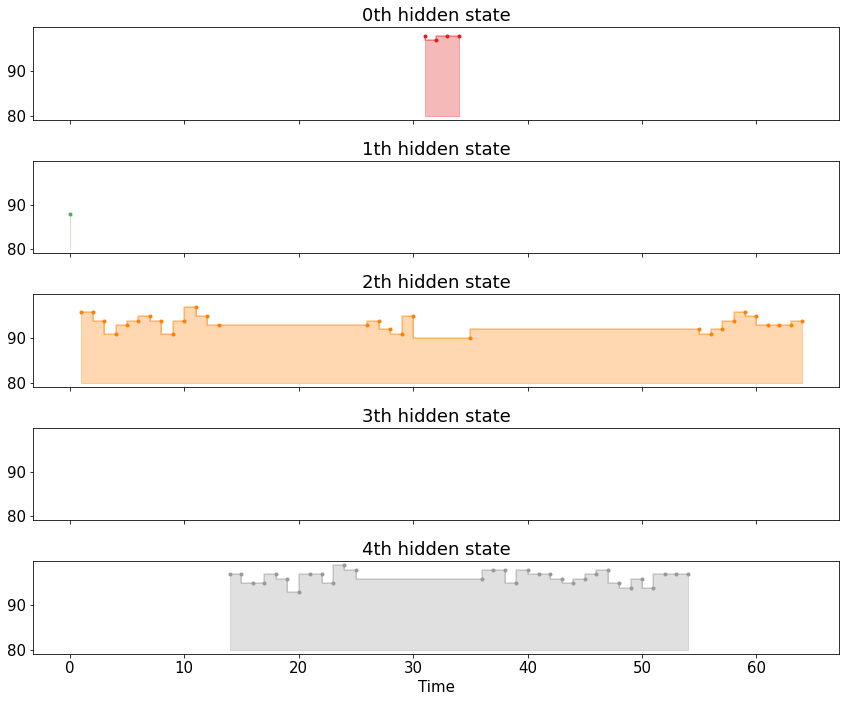

In [55]:
fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(12,10))
colors = cm.Set1(np.linspace(0, 1, model.n_components))

for i, (ax, color) in enumerate(zip(axs, colors)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    
    ax.fill_between(pd.Series(x1.flatten()).index.values[mask],
                 np.repeat(80, x1.flatten()[mask].shape[0]),
                 x1.flatten()[mask],
                 step="pre", 
                 color = color,
                 alpha=0.3)
    
    ax.plot(pd.Series(x1.flatten()).index.values[mask],
            x1.flatten()[mask],
            drawstyle="steps", 
            color = color,
            alpha = 0.4)
    
    ax.plot(pd.Series(x1.flatten()).index.values[mask],
                 x1.flatten()[mask],
                 ".", c=color)
    ax.set_title(f"{i}th hidden state")

plt.xlabel('Time')
plt.tight_layout()

Text(0, 0.5, 'Probability of a hidden state')

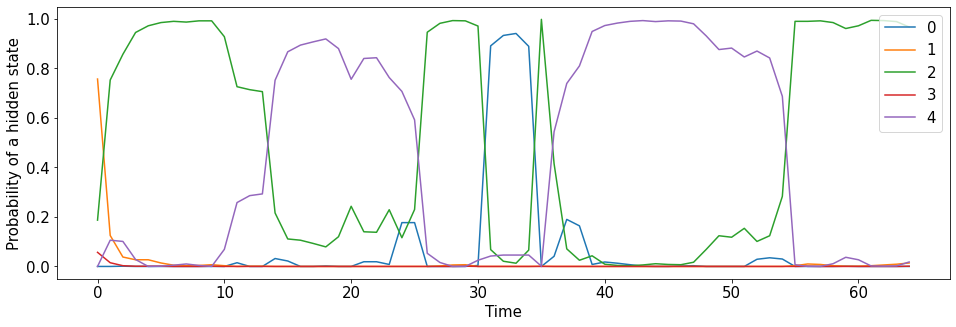

In [51]:
plt.figure(figsize=(16,5))

for i,s in enumerate(pred_prob):
    plt.plot(s, label =str(i))
plt.legend(loc = 'upper right')

plt.xlabel('Time')
plt.ylabel('Probability of a hidden state')

# Kết luận

Qua thí nghiệm này, chúng ta thấy mô hình Markov ẩn là một phương pháp hữu ích để học thông tin từ dữ liệu chuỗi trong hoàn cảnh ta chưa có một giả thuyết rõ ràng và muốn khảo sát đồng thời cả giá trị quan sát và yếu tố chuyển tiếp, thời gian trong cùng bài toán. Mô hình HMM có thể dùng được cho cả chuỗi giá trị định tính hoặc định lượng, thậm chí có thể mở rộng khảo sát đồng thời nhiều chuỗi song song (thí dụ SpO2 + mạch + huyết áp). 

Ghi chú: Vì lý do bảo mật, Nhi không chia sẻ dữ liệu, nhưng với nội dung code và cấu trúc dataframe, các bạn có thể dễ dàng tái lập thí nghiệm với dữ liệu mô phỏng hoặc bài toán tương tự.